### Overview of this notebook

* why transformers? transformers in `sktime`

    * transformers = modular data processing steps
    * simple pipeline example & transformer explained

* overview of transformer features

    * types of transformers - input types, output types
    * broadcasting/vectorization to panel, hierarchical, multivariate
    * searching for transformers using `all_estimators`

In [55]:
import warnings
warnings.filterwarnings('ignore')

---

# 2. Transformers in `sktime`

## 2.1 Wherefore transformers?

or: why sktime transformers will improve your life!

(disclaimer: not the same product as deep learning transformers)

suppose we want to forecast this well-known dataset
(airline passengers by year in a fixed scope)

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

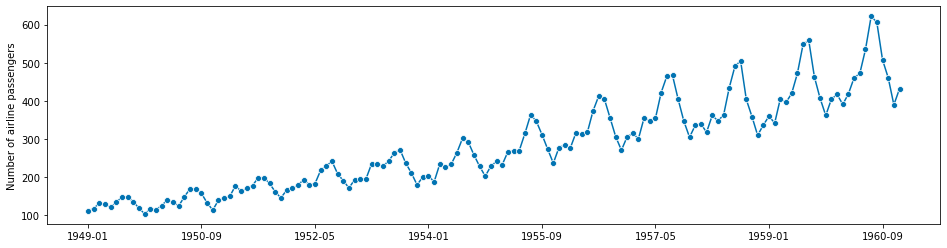

In [56]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

y = load_airline()
plot_series(y)

observations:

* there is seasonal periodicity, 12 month period
* seasonal periodicity looks multiplicative (not additive) to trend

idea: forecast might be easier

* with seasonality removed
* on logarithmic value scale (multiplication becomes addition)

### Naive approach - don't do this at home!

Maybe doing this manually step by step is a good idea?

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

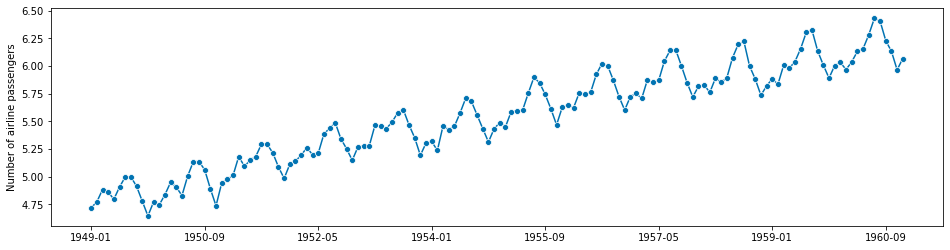

In [57]:
import numpy as np

# compute the logarithm
logy = np.log(y)

plot_series(logy)

this looks additive now!

ok, what next - deaseasonalization

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose

# apply this to y
# wait no, to logy

seasonal_result = seasonal_decompose(logy, period=12)

trend = seasonal_result.trend
resid = seasonal_result.resid
seasonal = seasonal_result.seasonal

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='trend'>)

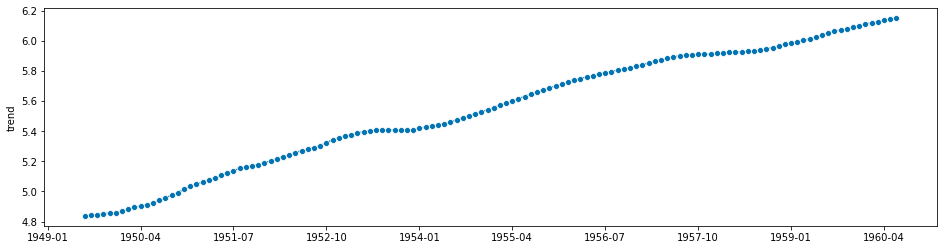

In [59]:
plot_series(trend)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='seasonal'>)

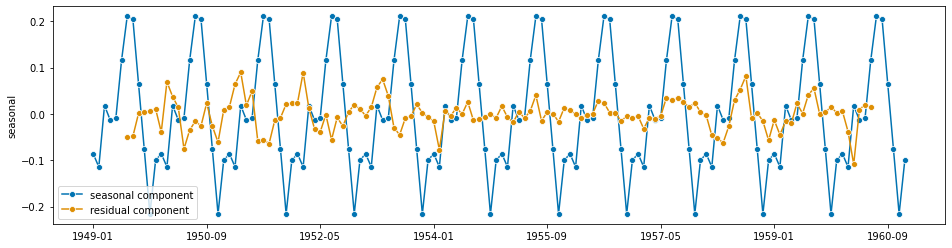

In [60]:
plot_series(seasonal, resid, labels=["seasonal component", "residual component"])

ok, now the forecast!

... of what ??

ah yes, residual plus trend, because seasonal just repeats itself

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

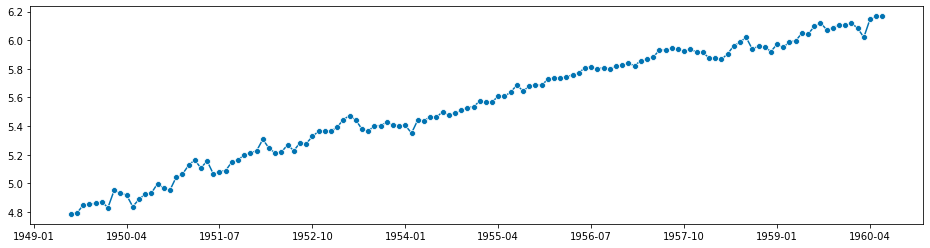

In [61]:
# forecast this:
plot_series(trend + resid)

In [62]:
# this has nans??
trend

1949-01   NaN
1949-02   NaN
1949-03   NaN
1949-04   NaN
1949-05   NaN
           ..
1960-08   NaN
1960-09   NaN
1960-10   NaN
1960-11   NaN
1960-12   NaN
Freq: M, Name: trend, Length: 144, dtype: float64

In [63]:
# ok, forecast this instead then:
y_to_forecast = logy - seasonal

# phew, no nans!
y_to_forecast

1949-01    4.804314
1949-02    4.885097
1949-03    4.864689
1949-04    4.872858
1949-05    4.804757
             ...   
1960-08    6.202368
1960-09    6.165645
1960-10    6.208669
1960-11    6.181992
1960-12    6.168741
Freq: M, Length: 144, dtype: float64

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

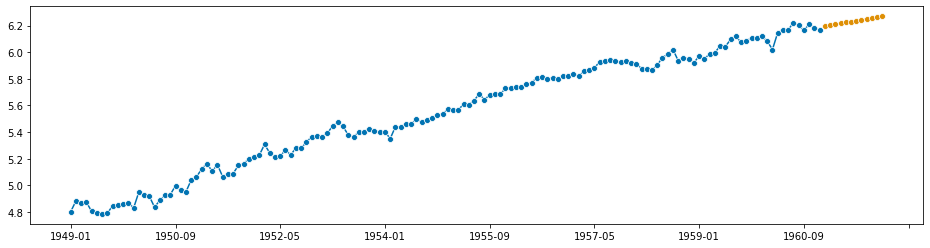

In [64]:
from sktime.forecasting.trend import PolynomialTrendForecaster

f = PolynomialTrendForecaster(degree=2)
f.fit(y_to_forecast, fh=list(range(1, 13)))
y_fcst = f.predict()

plot_series(y_to_forecast, y_fcst)

looks reasonable!

Now to turn this into a forecast of the original y ...

* add seasonal
* invert the logarithm

In [65]:
y_fcst

1961-01    6.195931
1961-02    6.202857
1961-03    6.209740
1961-04    6.216580
1961-05    6.223378
1961-06    6.230132
1961-07    6.236843
1961-08    6.243512
1961-09    6.250137
1961-10    6.256719
1961-11    6.263259
1961-12    6.269755
Freq: M, dtype: float64

In [66]:
y_fcst_orig = y_fcst + seasonal[0:12]
y_fcst_orig_orig = np.exp(y_fcst_orig)

y_fcst_orig_orig

1949-01   NaN
1949-02   NaN
1949-03   NaN
1949-04   NaN
1949-05   NaN
1949-06   NaN
1949-07   NaN
1949-08   NaN
1949-09   NaN
1949-10   NaN
1949-11   NaN
1949-12   NaN
1961-01   NaN
1961-02   NaN
1961-03   NaN
1961-04   NaN
1961-05   NaN
1961-06   NaN
1961-07   NaN
1961-08   NaN
1961-09   NaN
1961-10   NaN
1961-11   NaN
1961-12   NaN
Freq: M, dtype: float64

ok, that did not work. Something something pandas indices??

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

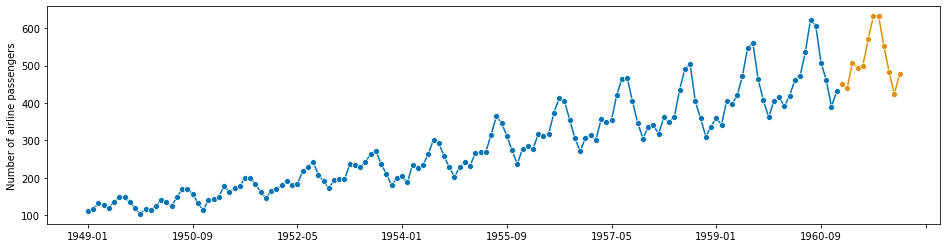

In [67]:
y_fcst_orig = y_fcst + seasonal[0:12].values
y_fcst_orig_orig = np.exp(y_fcst_orig)

plot_series(y, y_fcst_orig_orig)

ok, done! and it only took us 10 years.

Maybe there is a better way?

### Slightly less naive approach - use `sktime` transformers (badly)

Ok, surely there is a way where I don't have to fiddle with wildly varying interfaces of every step.

Solution: use transformers!

Same interface at every step!

In [68]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer


y = load_airline()

t_log = LogTransformer()
ylog = t_log.fit_transform(y)

t_deseason = Deseasonalizer(sp=12)
y_deseason = t_deseason.fit_transform(ylog)

f = PolynomialTrendForecaster(degree=2)
f.fit(y_deseason, fh=list(range(1,13)))
y_fcst = f.predict()

hm, but now we need to invert the transformations...

fortunately transformers have an inverse transform, standard interface point

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

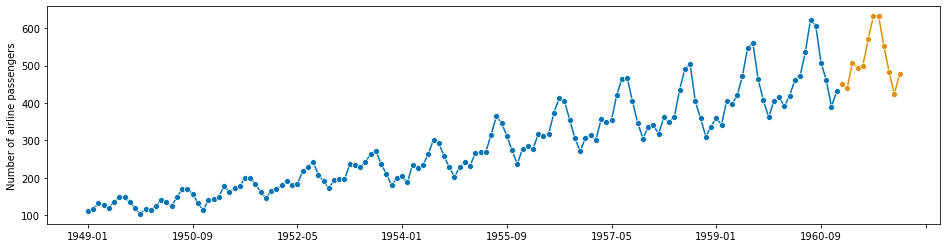

In [69]:
y_fcst_orig = t_deseason.inverse_transform(y_fcst)
# the deseasonalizer remembered the seasonality component! nice!

y_fcst_orig_orig = t_log.inverse_transform(y_fcst_orig)

plot_series(y, y_fcst_orig_orig)

### Expert approach - use `sktime` transformers with pipelines!

Bragging rights included.

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

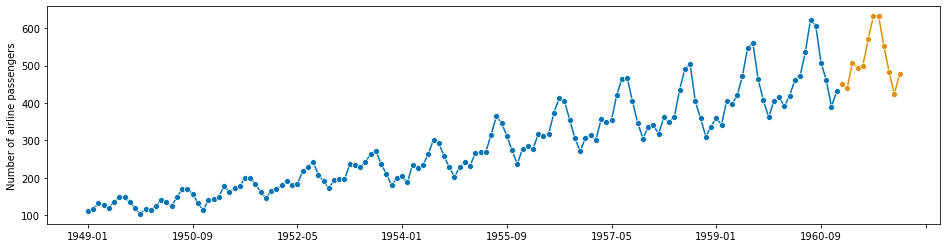

In [70]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer

y = load_airline()

f = LogTransformer() * Deseasonalizer(sp=12) * PolynomialTrendForecaster(degree=2)

f.fit(y, fh=list(range(1,13)))
y_fcst = f.predict()

plot_series(y, y_fcst)

what happened here?

The "chain" operator `*` creates a "forecasting pipeline"

Has the same interface as all other forecasters! No additional data fiddling!

Transformers "slot in" as standardized components.

In [71]:
f

TransformedTargetForecaster(steps=[LogTransformer(), Deseasonalizer(sp=12),
                                   PolynomialTrendForecaster(degree=2)])

Let's look at this in more detail:

* `sktime` transformers interface
* `sktime` pipeline building

## 2.2 Transformers - interface and features

* transformer interface
* transformer types
* searching transformers by type
* broadcasting/vectorization to panel & hierarchical data
* transformers and pipelines

### 2.2.1 What are transformers? <a class="anchor" id="section_1_1"></a>

Transformer = modular data processing steps commonly used in machine learning

("transformer" used in the sense of `scikit-learn`)

Transformers are estimators that:

* are fitted to a batch of data via `fit(data)`, changing its state
* are applied to another batch of data via `transform(X)`, producing transformed data
* may have an `inverse_transform(X)`

In `sktime`, input `X` to `fit` and `transform` is typically a time series or a panel (collection of time series).

Basic use of an `sktime` time series transformer is as follows:

In [72]:
# 1. prepare the data
from sktime.utils._testing.series import _make_series

X = _make_series()
X_train = X[:7]
X_test = X[7:12]
# X_train and X_test are both pandas.Series

X_train, X_test

(2000-01-01    3.810308
 2000-01-02    2.626056
 2000-01-03    4.097827
 2000-01-04    3.602006
 2000-01-05    2.944731
 2000-01-06    2.990342
 2000-01-07    3.742266
 Freq: D, dtype: float64,
 2000-01-08    2.286318
 2000-01-09    3.500190
 2000-01-10    3.294582
 2000-01-11    2.300136
 2000-01-12    3.096189
 Freq: D, dtype: float64)

In [73]:
# 2. construct the transformer
from sktime.transformations.series.boxcox import BoxCoxTransformer

# trafo is an sktime estimator inheriting from BaseTransformer
# Box-Cox transform with lambda parameter fitted via mle
trafo = BoxCoxTransformer(method="mle")

In [74]:
# 3. fit the transformer to training data
trafo.fit(X_train)

# 4. apply the transformer to transform test data
# Box-Cox transform with lambda fitted on X_train
X_transformed = trafo.transform(X_test)

X_transformed

2000-01-08    1.751395
2000-01-09    4.127293
2000-01-10    3.680987
2000-01-11    1.774777
2000-01-12    3.266751
Freq: D, dtype: float64

If the training and test set is the same, step 3 and 4 can be carried out more concisely (and sometimes more efficiently) by using `fit_transform`:

In [75]:
# 3+4. apply the transformer to fit and transform on the same data, X
X_transformed = trafo.fit_transform(X)

### 2.2.2 Different types of transformers <a class="anchor" id="section_1_2"></a>

`sktime` distinguishes different types of transformer, depending on the input type of `fit` and `transform`, and the output type of `transform`.

Transformers differ by:

* making use of an additional `y` argument in `fit` or `transform`
* whether the input to `fit` and `transform` is a single time series, a collection of time series, or scalar values (data frame row)
* whether the output of `transform` is a single time series, a collection of time series, or scalar values (data frame row)
* whether the input to `fit` and `transform` are one object or two. Two objects as input and a scalar output means the transformer is a distance or kernel function.

More detail on this is given in the glossary (section 2.3).

To illustrate the difference, we compare two transformers with different output:

* the Box-Cox transformer `BoxCoxTrannsformer`, which transforms a time series to a time series
* the summary transformer `SummaryTransformer`, which transforms a time series to scalars such as the mean


In [76]:
# constructing the transformer
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.transformations.series.summarize import SummaryTransformer
from sktime.utils._testing.series import _make_series

# getting some data
# this is one pandas.Series
X = _make_series(n_timepoints=10)

# constructing the transformers
boxcox_trafo = BoxCoxTransformer(method="mle")
summary_trafo = SummaryTransformer()

In [77]:
# this produces a pandas Series
boxcox_trafo.fit_transform(X)

2000-01-01    0.980845
2000-01-02    0.120876
2000-01-03    2.356607
2000-01-04    1.589674
2000-01-05    1.881648
2000-01-06    0.000000
2000-01-07    2.684270
2000-01-08    1.087283
2000-01-09    1.071261
2000-01-10    2.301499
Freq: D, dtype: float64

In [78]:
# this produces a pandas.DataFrame row
summary_trafo.fit_transform(X)

,mean,std,min,max,0.1,0.25,0.5,0.75,0.9
0,2.245217,0.788246,1.0,3.301137,1.107466,1.927995,2.212934,2.917034,3.07038


For time series transformers, the metadata tags describe the expected output of `transform`:

In [79]:
boxcox_trafo.get_tag("scitype:transform-output")

'Series'

In [80]:
summary_trafo.get_tag("scitype:transform-output")

'Primitives'

To find transformers, use `all_estimators` and filter by tags:

* `"scitype:transform-output"` - the output scitype. `Series` for time series, `Primitives` for primitive features (float, categories), `Panel` for collections of time series.
* `"scitype:transform-input"` - the input scitype. `Series` for time series.
* `"scitype:instancewise"` - If `True`, vectorized operation per series. If `False`, uses multiple time series non-trivially.

Example: find all transformers that output time series

In [81]:
from sktime.registry import all_estimators

# now subset to transformers that extract scalar features
all_estimators(
    "transformer",
    as_dataframe=True,
    filter_tags={"scitype:transform-output": "Series"},
)

,name,estimator
0,Aggregator,<class 'sktime.transformations.hierarchical.ag...
1,AutoCorrelationTransformer,<class 'sktime.transformations.series.acf.Auto...
2,BoxCoxTransformer,<class 'sktime.transformations.series.boxcox.B...
3,ClaSPTransformer,<class 'sktime.transformations.series.clasp.Cl...
4,ClearSky,<class 'sktime.transformations.series.clear_sk...
...,...,...
69,TransformerPipeline,<class 'sktime.transformations.compose.Transfo...
70,TruncationTransformer,<class 'sktime.transformations.panel.truncatio...
71,WhiteNoiseAugmenter,<class 'sktime.transformations.series.augmente...
72,WindowSummarizer,<class 'sktime.transformations.series.summariz...


A more complete overview on transformer types and tags is given in the `sktime` transformers tutorial.


### 2.2.3 Broadcasting aka vectorization of transformers <a class="anchor" id="section_1_3"></a>

`sktime` transformers may be natively univariate, or apply only to a single time series.

Even if this is the case, they broadcast across variables and instances of time series, where applicable (als known as vectorization in `numpy` parlance).

This ensures that all `sktime` transformers can be applied to multivariate and multi-instance (panel, hierarchical) time series data.

Example 1: broadcasting/vectorization of time series to time series transformer

The `BoxCoxTransformer` from previous sections applies to single instances of univariate time series. When multiple instances or variables are seen, it broadcasts across both:

In [82]:
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.utils._testing.hierarchical import _make_hierarchical

# hierarchical data with 2 variables and 2 levels
X = _make_hierarchical(n_columns=2)

X

c0        c1
h0   h1   time                          
h0_0 h1_0 2000-01-01  2.683822  1.845969
          2000-01-02  4.787941  2.724499
          2000-01-03  2.957583  3.758586
          2000-01-04  2.355368  3.137919
          2000-01-05  2.882347  3.619553
...                        ...       ...
h0_1 h1_3 2000-01-08  4.961863  3.369065
          2000-01-09  3.438742  3.644035
          2000-01-10  2.152565  3.545259
          2000-01-11  3.928812  4.721102
          2000-01-12  4.737011  1.000000

[96 rows x 2 columns]

In [83]:
# constructing the transformers
boxcox_trafo = BoxCoxTransformer(method="mle")

# applying to X results in hierarchical data
boxcox_trafo.fit_transform(X)

c0        c1
h0   h1   time                          
h0_0 h1_0 2000-01-01  0.680545  0.901383
          2000-01-02  0.889043  1.925224
          2000-01-03  0.722663  3.211851
          2000-01-04  0.618479  2.430314
          2000-01-05  0.711809  3.034532
...                        ...       ...
h0_1 h1_3 2000-01-08  3.175221  3.557117
          2000-01-09  2.070465  4.096312
          2000-01-10  1.047188  3.900011
          2000-01-11  2.436083  6.416536
          2000-01-12  3.017552  0.000000

[96 rows x 2 columns]

Fitted model components of vectorized transformers can be found in the `transformers_` attribute, or accessed via the universal `get_fitted_params` interface:

In [84]:
boxcox_trafo.transformers_
# this is a pandas.DataFrame that contains the fitted transformers
# one per time series instance and variable

c0                   c1
h0   h1                                            
h0_0 h1_0  BoxCoxTransformer()  BoxCoxTransformer()
     h1_1  BoxCoxTransformer()  BoxCoxTransformer()
     h1_2  BoxCoxTransformer()  BoxCoxTransformer()
     h1_3  BoxCoxTransformer()  BoxCoxTransformer()
h0_1 h1_0  BoxCoxTransformer()  BoxCoxTransformer()
     h1_1  BoxCoxTransformer()  BoxCoxTransformer()
     h1_2  BoxCoxTransformer()  BoxCoxTransformer()
     h1_3  BoxCoxTransformer()  BoxCoxTransformer()

In [85]:
boxcox_trafo.get_fitted_params()
# this returns a dictionary
# the transformers DataFrame is available at the key "transformers"
# individual transformers are available at dataframe-like keys
# it also contains all fitted lambdas as keyed parameters

{'transformers':                             c0                   c1
 h0   h1                                            
 h0_0 h1_0  BoxCoxTransformer()  BoxCoxTransformer()
      h1_1  BoxCoxTransformer()  BoxCoxTransformer()
      h1_2  BoxCoxTransformer()  BoxCoxTransformer()
      h1_3  BoxCoxTransformer()  BoxCoxTransformer()
 h0_1 h1_0  BoxCoxTransformer()  BoxCoxTransformer()
      h1_1  BoxCoxTransformer()  BoxCoxTransformer()
      h1_2  BoxCoxTransformer()  BoxCoxTransformer()
      h1_3  BoxCoxTransformer()  BoxCoxTransformer(),
 "transformers.loc[('h0_0', 'h1_0'),c0]": BoxCoxTransformer(),
 "transformers.loc[('h0_0', 'h1_0'),c0]__lambda": -0.8069475884553494,
 "transformers.loc[('h0_0', 'h1_1'),c1]": BoxCoxTransformer(),
 "transformers.loc[('h0_0', 'h1_1'),c1]__lambda": 0.12341246963903162}

Example 2: broadcasting/vectorization of time series to scalar features transformer

The `SummaryTransformer` behaves similarly.
Multiple time series instances are transformed to different columns of the resulting data frame.

In [86]:
from sktime.transformations.series.summarize import SummaryTransformer

summary_trafo = SummaryTransformer()

# this produces a pandas DataFrame with more rows and columns
# rows correspond to different instances in X
# columns are multiplied and names prefixed by [variablename]__
# there is one column per variable and transformed feature
summary_trafo.fit_transform(X)

c0__mean   c0__std   c0__min   c0__max   c0__0.1  c0__0.25  \
h0   h1                                                                 
h0_0 h1_0  3.363502  0.888455  2.326292  4.842620  2.388213  2.710300   
     h1_1  3.644995  1.078532  1.903734  5.270589  2.034740  3.121134   
     h1_2  3.594787  0.783047  1.937518  4.625312  2.866791  2.997500   
     h1_3  3.171006  0.858720  1.929355  4.411731  1.987958  2.542017   
h0_1 h1_0  3.310270  0.765086  2.091585  4.624920  2.763195  2.825952   
     h1_1  3.306371  0.694521  2.117480  4.611674  2.531900  2.862510   
     h1_2  3.277546  1.389121  1.000000  5.247397  1.597465  2.103103   
     h1_3  3.595113  0.803093  2.152565  4.961863  2.877159  3.075669   

            c0__0.5  c0__0.75   c0__0.9  c1__mean   c1__std   c1__min  \
h0   h1                                                                 
h0_0 h1_0  3.148867  3.806979  4.746644  3.081603  0.944588  1.425576   
     h1_1  3.778242  4.310319  4.820168  3.161362  1.048064  1.659595   
     h1_2  3.716011  4.153105  4.428266  3.112988  1.021791  1.737795   
     h1_3  3.122729  3.790359  4.308150  3.352978  0.730577  2.432276   
h0_1 h1_0  3.061734  3.823606  4.470185  3.787161  0.904364  2.511263   
     h1_1  3.382356  3.630755  4.109123  3.414667  0.989845  1.998801   
     h1_2  3.504154  4.193908  4.995418  3.667980  1.224995  1.928143   
     h1_3  3.638645  3.968835  4.672200  3.415453  1.165435  1.000000   

            c1__max   c1__0.1  c1__0.25   c1__0.5  c1__0.75   c1__0.9  
h0   h1                                                                
h0_0 h1_0  4.801806  1.861491  2.543671  3.305919  3.626756  3.747564  
     h1_1  5.336684  2.022367  2.515959  2.835354  3.836080  4.123579  
     h1_2  4.797341  1.772166  2.166341  3.278153  3.665638  4.363603  
     h1_3  4.485116  2.626465  2.715674  3.349464  3.932822  4.281664  
h0_1 h1_0  5.615340  3.047052  3.228074  3.437344  4.467781  4.788264  
     h1_1  4.947076  2.165703  2.968409  3.181171  3.910247  4.847644  
     h1_2  5.456202  2.164935  2.586204  3.784866  4.477500  5.275622  
     h1_3  4.826706  2.216537  2.650219  3.594647  4.268162  4.716994

### 2.2.4 Transformers as pipeline components <a class="anchor" id="section_1_4"></a>

`sktime` transformers can be pipelined with any other `sktime` estimator type, including forecasters, classifiers, and other transformers.

Pipelines = estimators of the same type, same interface as specialized class

pipeline build operation: `make_pipeline` or via `*` dunder

Pipelining `pipe = trafo * est` produces `pipe` of same type as `est`.

In `pipe.fit`, first `trafo.fit_transform`, then `est.fit` is executed on the result.

In `pipe.predict`, first `trafo.transform`, then `est.predict` is executed.

(the arguments that are piped differ by type and can be looked up in the docstrings of pipeline classes, or specialized tutorials)

#### Example 1: forecaster pipeline

we have seen this example above

In [87]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer

y = load_airline()

pipe = LogTransformer() * Deseasonalizer(sp=12) * PolynomialTrendForecaster(degree=2)

pipe

TransformedTargetForecaster(steps=[LogTransformer(), Deseasonalizer(sp=12),
                                   PolynomialTrendForecaster(degree=2)])

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

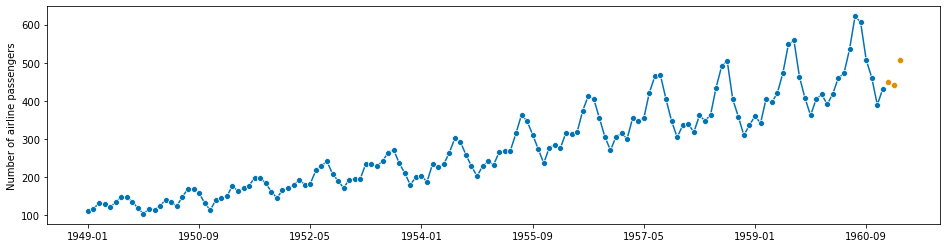

In [88]:
# this is a forecaster with the same interface as Polynomial Trend Forecaster
pipe.fit(y, fh=[1, 2, 3])
y_pred = pipe.predict()

plot_series(y, y_pred)

#### Example 2: classifier pipeline

works the same with classifiers or other estimator types!

In [89]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.transformations.series.exponent import ExponentTransformer

pipe = ExponentTransformer() * KNeighborsTimeSeriesClassifier()

# this constructs a ClassifierPipeline, which is also a classifier
pipe

ClassifierPipeline(classifier=KNeighborsTimeSeriesClassifier(),
                   transformers=[ExponentTransformer()])

In [90]:
from sktime.datasets import load_unit_test

X_train, y_train = load_unit_test(split="TRAIN")
X_test, _ = load_unit_test(split="TEST")

# this is a forecaster with the same interface as knn-classifier
# first applies exponent transform, then knn-classifier
pipe.fit(X_train, y_train)

ClassifierPipeline(classifier=KNeighborsTimeSeriesClassifier(),
                   transformers=[ExponentTransformer()])

## 2.3 Combining transformers, feature engineering

transformers are natural pipeline components

* data processing steps
* feature engineering steps
* post processing steps

they can be combined in a number of other ways:

* pipelining = sequential chaining
* feature union = parallel, addition of features
* feature subsetting = selecting columns
* inversion = switch transform and inverse
* multiplexing = switching between transformers
* passthrough = switch on/ off

### Chaining transformers via `*`

In [91]:
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.summarize import SummaryTransformer

pipe = Differencer() * SummaryTransformer()

# this constructs a TransformerPipeline, which is also a transformer
pipe

TransformerPipeline(steps=[Differencer(), SummaryTransformer()])

In [92]:
from sktime.utils._testing.hierarchical import _bottom_hier_datagen

X = _bottom_hier_datagen(no_levels=1, no_bottom_nodes=2)

# this is a transformer with the same interface
# first applies differencer, then summary transform
pipe.fit_transform(X)

,mean,std,min,max,0.1,0.25,0.5,0.75,0.9
0,2.222222,33.636569,-101.0,87.0,-37.70,-16.0,3.5,22.25,43.0
1,34.666667,524.730483,-1575.6,1357.2,-588.12,-249.6,54.6,347.10,670.8


compatible with sklearn transformers!

default applies sklearn transformer per individual time series as a data frame table

In [93]:
from sklearn.preprocessing import StandardScaler

pipe = Differencer() * StandardScaler()

pipe

TransformerPipeline(steps=[Differencer(),
                           TabularToSeriesAdaptor(transformer=StandardScaler())])

In [94]:
pipe.fit_transform(X)

passengers
l1_agg    timepoints            
l1_node01 1949-01      -0.066296
          1949-02       0.112704
          1949-03       0.351370
          1949-04      -0.155796
          1949-05      -0.304963
...                          ...
l1_node02 1960-08      -0.543629
          1960-09      -2.989961
          1960-10      -1.468462
          1960-11      -2.184462
          1960-12       1.186703

[288 rows x 1 columns]

pipeline-adaptor chains can be constructed manually:

* `sktime.transformations.compose.TransformerPipeline`
* `sktime.transformations.series.adapt.TabularToSeriesAdaptor` for `sklearn`

composites are compatible with `get_params` / `set_params` parameter interface:

In [95]:
pipe.get_params()

{'steps': [Differencer(),
  TabularToSeriesAdaptor(transformer=StandardScaler())],
 'Differencer': Differencer(),
 'TabularToSeriesAdaptor': TabularToSeriesAdaptor(transformer=StandardScaler()),
 'Differencer__lags': 1,
 'Differencer__memory': 'all',
 'Differencer__na_handling': 'fill_zero',
 'TabularToSeriesAdaptor__fit_in_transform': False,
 'TabularToSeriesAdaptor__transformer__copy': True,
 'TabularToSeriesAdaptor__transformer__with_mean': True,
 'TabularToSeriesAdaptor__transformer__with_std': True,
 'TabularToSeriesAdaptor__transformer': StandardScaler()}

### Feature union via `+`

In [96]:
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Differencer() + Lag()

# this constructs a FeatureUnion, which is also a transformer
pipe

FeatureUnion(transformer_list=[Differencer(), Lag()])

In [97]:
from sktime.utils._testing.hierarchical import _bottom_hier_datagen

X = _bottom_hier_datagen(no_levels=1, no_bottom_nodes=2)

# applies both Differencer and Lag, returns transformed in different columns
pipe.fit_transform(X)

Differencer__passengers  Lag__lag_0__passengers
l1_agg    timepoints                                                 
l1_node01 1949-01                        0.00                  112.00
          1949-02                        6.00                  118.00
          1949-03                       14.00                  132.00
          1949-04                       -3.00                  129.00
          1949-05                       -8.00                  121.00
...                                       ...                     ...
l1_node02 1960-08                    -1862.72                40403.56
          1960-09                   -10515.40                29888.16
          1960-10                    -4497.90                25390.26
          1960-11                    -6124.46                19265.80
          1960-12                     3525.48                22791.28

[288 rows x 2 columns]

to retain the original columns, use the `Id` transformer:

In [98]:
from sktime.transformations.compose import Id
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Id() + Differencer() + Lag([1, 2], index_out="original")

pipe.fit_transform(X)

Id__passengers  Differencer__passengers  \
l1_agg    timepoints                                            
l1_node01 1949-01             112.00                     0.00   
          1949-02             118.00                     6.00   
          1949-03             132.00                    14.00   
          1949-04             129.00                    -3.00   
          1949-05             121.00                    -8.00   
...                              ...                      ...   
l1_node02 1960-08           40403.56                 -1862.72   
          1960-09           29888.16                -10515.40   
          1960-10           25390.26                 -4497.90   
          1960-11           19265.80                 -6124.46   
          1960-12           22791.28                  3525.48   

                      Lag__lag_1__passengers  Lag__lag_2__passengers  
l1_agg    timepoints                                                  
l1_node01 1949-01                        NaN                     NaN  
          1949-02                     112.00                     NaN  
          1949-03                     118.00                  112.00  
          1949-04                     132.00                  118.00  
          1949-05                     129.00                  132.00  
...                                      ...                     ...  
l1_node02 1960-08                   42266.28                32631.90  
          1960-09                   40403.56                42266.28  
          1960-10                   29888.16                40403.56  
          1960-11                   25390.26                29888.16  
          1960-12                   19265.80                25390.26  

[288 rows x 4 columns]

In [99]:
# parameter inspection
pipe.get_params()

{'flatten_transform_index': True,
 'n_jobs': None,
 'transformer_list': [Id(),
  Differencer(),
  Lag(index_out='original', lags=[1, 2])],
 'transformer_weights': None,
 'Id': Id(),
 'Differencer': Differencer(),
 'Lag': Lag(index_out='original', lags=[1, 2]),
 'Id___output_convert': 'auto',
 'Differencer__lags': 1,
 'Differencer__memory': 'all',
 'Differencer__na_handling': 'fill_zero',
 'Lag__flatten_transform_index': True,
 'Lag__freq': None,
 'Lag__index_out': 'original',
 'Lag__keep_column_names': False,
 'Lag__lags': [1, 2]}

### Subset input columns via `[colname]`

let's say we want to apply `Differencer` to column 0, and `Lag` to column 1

also we keep the original columns for illustration

In [100]:
from sktime.utils._testing.hierarchical import _make_hierarchical

X = _make_hierarchical(
    hierarchy_levels=(2, 2), n_columns=2, min_timepoints=3, max_timepoints=3
)

X

c0        c1
h0   h1   time                          
h0_0 h1_0 2000-01-01  3.619319  2.342345
          2000-01-02  3.989470  1.506103
          2000-01-03  2.404292  1.883536
     h1_1 2000-01-01  2.401352  1.217871
          2000-01-02  4.232443  1.484781
          2000-01-03  2.289995  2.745453
h0_1 h1_0 2000-01-01  2.967151  2.027123
          2000-01-02  4.993014  2.714446
          2000-01-03  3.551998  1.942911
     h1_1 2000-01-01  1.000000  2.747102
          2000-01-02  3.202836  2.505074
          2000-01-03  5.200986  1.000000

In [101]:
from sktime.transformations.compose import Id
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Id() + Differencer()["c0"] + Lag([1, 2], index_out="original")["c1"]

pipe.fit_transform(X)

Id__c0    Id__c1  TransformerPipeline_1__c0  \
h0   h1   time                                                        
h0_0 h1_0 2000-01-01  3.619319  2.342345                   0.000000   
          2000-01-02  3.989470  1.506103                   0.370150   
          2000-01-03  2.404292  1.883536                  -1.585177   
     h1_1 2000-01-01  2.401352  1.217871                   0.000000   
          2000-01-02  4.232443  1.484781                   1.831091   
          2000-01-03  2.289995  2.745453                  -1.942448   
h0_1 h1_0 2000-01-01  2.967151  2.027123                   0.000000   
          2000-01-02  4.993014  2.714446                   2.025863   
          2000-01-03  3.551998  1.942911                  -1.441015   
     h1_1 2000-01-01  1.000000  2.747102                   0.000000   
          2000-01-02  3.202836  2.505074                   2.202836   
          2000-01-03  5.200986  1.000000                   1.998150   

                      TransformerPipeline_2__lag_1__c1  \
h0   h1   time                                           
h0_0 h1_0 2000-01-01                               NaN   
          2000-01-02                          2.342345   
          2000-01-03                          1.506103   
     h1_1 2000-01-01                               NaN   
          2000-01-02                          1.217871   
          2000-01-03                          1.484781   
h0_1 h1_0 2000-01-01                               NaN   
          2000-01-02                          2.027123   
          2000-01-03                          2.714446   
     h1_1 2000-01-01                               NaN   
          2000-01-02                          2.747102   
          2000-01-03                          2.505074   

                      TransformerPipeline_2__lag_2__c1  
h0   h1   time                                          
h0_0 h1_0 2000-01-01                               NaN  
          2000-01-02                               NaN  
          2000-01-03                          2.342345  
     h1_1 2000-01-01                               NaN  
          2000-01-02                               NaN  
          2000-01-03                          1.217871  
h0_1 h1_0 2000-01-01                               NaN  
          2000-01-02                               NaN  
          2000-01-03                          2.027123  
     h1_1 2000-01-01                               NaN  
          2000-01-02                               NaN  
          2000-01-03                          2.747102

auto-generated names can be replaced by using `FeatureUnion` explicitly:

In [102]:
from sktime.transformations.compose import FeatureUnion

pipe = FeatureUnion(
    [
        ("original", Id()),
        ("diff", Differencer()["c0"]),
        ("lag", Lag([1, 2], index_out="original")),
    ]
)

pipe.fit_transform(X)

original__c0  original__c1  diff__c0  lag__lag_1__c0  \
h0   h1   time                                                               
h0_0 h1_0 2000-01-01      3.619319      2.342345  0.000000             NaN   
          2000-01-02      3.989470      1.506103  0.370150        3.619319   
          2000-01-03      2.404292      1.883536 -1.585177        3.989470   
     h1_1 2000-01-01      2.401352      1.217871  0.000000             NaN   
          2000-01-02      4.232443      1.484781  1.831091        2.401352   
          2000-01-03      2.289995      2.745453 -1.942448        4.232443   
h0_1 h1_0 2000-01-01      2.967151      2.027123  0.000000             NaN   
          2000-01-02      4.993014      2.714446  2.025863        2.967151   
          2000-01-03      3.551998      1.942911 -1.441015        4.993014   
     h1_1 2000-01-01      1.000000      2.747102  0.000000             NaN   
          2000-01-02      3.202836      2.505074  2.202836        1.000000   
          2000-01-03      5.200986      1.000000  1.998150        3.202836   

                      lag__lag_1__c1  lag__lag_2__c0  lag__lag_2__c1  
h0   h1   time                                                        
h0_0 h1_0 2000-01-01             NaN             NaN             NaN  
          2000-01-02        2.342345             NaN             NaN  
          2000-01-03        1.506103        3.619319        2.342345  
     h1_1 2000-01-01             NaN             NaN             NaN  
          2000-01-02        1.217871             NaN             NaN  
          2000-01-03        1.484781        2.401352        1.217871  
h0_1 h1_0 2000-01-01             NaN             NaN             NaN  
          2000-01-02        2.027123             NaN             NaN  
          2000-01-03        2.714446        2.967151        2.027123  
     h1_1 2000-01-01             NaN             NaN             NaN  
          2000-01-02        2.747102             NaN             NaN  
          2000-01-03        2.505074        1.000000        2.747102

### turning log transform into exp transform via invert `~`

In [103]:
import numpy as np

from sktime.transformations.series.boxcox import LogTransformer

log = LogTransformer()

exp = ~log

# this behaves like an "e to the power of" transformer now
exp.fit_transform(np.array([1, 2, 3]))

array([ 2.71828183,  7.3890561 , 20.08553692])

### autoML structure compositors: multiplexer switch `¦` and on/off switch `-`

expose decisions as parameter

* do we want differencer *or* lag? for tuning later
* do we want [differencer and lag] or [original features and lag] ? for tuning later

In [104]:
# differencer or lag

from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Differencer() | Lag()

pipe.get_params()

{'selected_transformer': None,
 'transformers': [Differencer(), Lag()],
 'Differencer': Differencer(),
 'Lag': Lag(),
 'Differencer__lags': 1,
 'Differencer__memory': 'all',
 'Differencer__na_handling': 'fill_zero',
 'Lag__flatten_transform_index': True,
 'Lag__freq': None,
 'Lag__index_out': 'extend',
 'Lag__keep_column_names': False,
 'Lag__lags': 0}

the `selected_transformer` parameter exposes the choice:

does this behave as `Lag` or `Differencer`?

In [105]:
# switch = Lag -> this is a Lag transformer now!
pipe.set_params(selected_transformer="Lag")

MultiplexTransformer(selected_transformer='Lag',
                     transformers=[Differencer(), Lag()])

In [106]:
# switch = Lag -> this is a Differencer now!
pipe.set_params(selected_transformer="Differencer")

MultiplexTransformer(selected_transformer='Differencer',
                     transformers=[Differencer(), Lag()])

similar, on/off switch with `~`

same as multiplexer between wrapped transformer and `Id`

In [107]:
optional_differencer = - Differencer()

# this behaves as Differencer now
optional_differencer

OptionalPassthrough(transformer=Differencer())

In [108]:
# this is now just the identity transformer
optional_differencer.set_params(passthrough=True)

OptionalPassthrough(passthrough=True, transformer=Differencer())

see more later in part 3 on how to use this with tuning for full structural AutoML!

## 2.4 Appendix - cheat sheets and extension guie

### dunders glossary

| Type | Dunder | Meaning | `sktime` class |
| --- | --- | --- | --- |
| compose | `*` | chaining/pipeline - also works with other estimator types | type dependent |
| compose | `**` | chaining to secondary input of another estimator | type dependent |
| compose | `+` | feature union | `FeatureUnion` |
| interface | `~` | invert | `InvertTransform` |
| structural | `¦` | multiplexing ("switch") | type dependent |
| structural | `-` | optional passthrough ("on/off") | `OptionalPassthrough` |

### selected useful transformers, compositors, adapters

* delay fitting to `transform` via `sktime.transformations.compose.FitInTransform`
* any `pandas` method via `sktime.transformations.compose.adapt.PandasTransformAdaptor`
* date/time features via `sktime.transformations.series.date.DateTimeFeatures`
* lags via `transformations.series.lag.Lag`
* differences, first and n-th, via `transformations.series.difference.Differencer`
* scaled logit via `transformations.series.scaledlogit.ScaledLogitTransform`

### Transformer type glossary

Common types of transformation in `sktime`:

| from | to | base class | examples (sci) | examples (`sktime`) |
| --- | --- | --- | --- | --- |
| time series | scalar features | `BaseTransformer` (`Primitives` output) | `tsfresh`, or 7-number-summary | `Catch22`, `SummaryTransformer` |
| time series | time series | `BaseTransformer` (`Series`, `instancewise`)  | detrending, smoothing, filtering, lagging | `Detrender`, `Differencer`, `Lag`, `Filter` |
| time series panel | also a panel | `BaseTransformer` (`Series` output)  | principal component projection | `PCATransformer`, `PaddingTransformer` |
| two feature vectors | a scalar | `BasePairwiseTransformer` | Euclidean distance, L1 distance | `ScipyDist`, `AggrDist`, `FlatDist` |
| two time series | a scalar | `BasePairwiseTransformerPanel` | DTW distance, alignment kernel | `DtwDist`, `EditDist` |

first three = "time series transformers", or, simply, "transformers"

all "transformers" follow the same base interface.

"pairwise transformers" have separate base interface (due to two inputs)

include distances and kernels between time series or feature vectors

all inherit `BaseObject` and follow unified `skbase` interface with `get_params`, `get_fitted_params`, etc

### Extension guide - implementing your own transformer<a class="anchor" id="chapter4"></a>

`sktime` is meant to be easily extensible, for direct contribution to `sktime` as well as for local/private extension with custom methods.

To extend `sktime` with a new local or contributed transformer, a good workflow to follow is:

1. read through the [transformer extension template](https://github.com/alan-turing-institute/sktime/blob/main/extension_templates/transformer.py) - this is a `python` file with `todo` blocks that mark the places in which changes need to be added.
2. optionally, if you are planning any major surgeries to the interface: look at the [base class architecture](https://github.com/alan-turing-institute/sktime/blob/main/sktime/transformations/base.py) - note that "ordinary" extension (e.g., new algorithm) should be easily doable without this.
3. copy the transformer extension template to a local folder in your own repository (local/private extension), or to a suitable location in your clone of the `sktime` or affiliated repository (if contributed extension), inside `sktime.transformations`; rename the file and update the file docstring appropriately.
4. address the "todo" parts. Usually, this means: changing the name of the class, setting the tag values, specifying hyper-parameters, filling in `__init__`, `_fit`, `_transform`, and optional methods such as `_inverse_transform` or `_update` (for details see the extension template). You can add private methods as long as they do not override the default public interface. For more details, see the extension template.
5. to test your estimator manually: import your estimator and run it in the worfklows in Section 2.2; then use it in the compositors in Section 2.3.
6. to test your estimator automatically: call `sktime.tests.test_all_estimators.check_estimator` on your estimator. You can call this on a class or object instance. Ensure you have specified test parameters in the `get_test_params` method, according to the extension template.

In case of direct contribution to `sktime` or one of its affiliated packages, additionally:
* add yourself as an author to the code, and to the `CODEOWNERS` for the new estimator file(s).
* create a pull request that contains only the new estimators (and their inheritance tree, if it's not just one class), as well as the automated tests as described above.
* in the pull request, describe the estimator and optimally provide a publication or other technical reference for the strategy it implements.
* before making the pull request, ensure that you have all necessary permissions to contribute the code to a permissive license (BSD-3) open source project.

## 2.5 Summary<a class="anchor" id="chapter5"></a>

* transformers are data processing steps with unified interface - `fit`, `transform`, and optional `inverse_transform`

* used as pipeline components for any learning task, forecasting, classification

* different types by input/output - time series, primitives, pairs of time series, panels/hierarchical.

* find transformers by tags such as `scitype:transform-output` and `scitype:instancewise` using `all_estimators`

* rich composition syntax - `*` for pipe, `+` for featureunion, `[in, out]` for variable subset, `|` for multiplex/switch

* `sktime` provides easy-to-use extension templates for transformers, build your own, plug and play

---

### Credits: notebook 2 - transformers

notebook creation: fkiraly

transformer pipelines & compositors: fkiraly, mloning, miraep8\
forecaster pipelines: fkiraly, aiwalter\
classifier/regressor pipelines: fkiraly\
transformer base interface: mloning, fkiraly\
dunder interface: fkiraly, miraep8

Based on design ideas: sklearn, magrittr, mlr, mlj